# Librerías e importaciones

In [206]:
!pip install meteostat
!pip install geocoder
!pip install geopy

In [207]:
import pandas as pd
import json
import ast
import geocoder
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
from meteostat import Point, Hourly, Daily, Monthly
import fbprophet as ph
import datetime

# Exploración de datos

In [208]:
# Acceso a gdrive para datos
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/My Drive/Saturdays_AI_DL"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [209]:
dfconsumption = pd.read_csv(path + "/holaluz/consumptions_small.csv", sep=';')
dfcups = pd.read_csv(path + "/holaluz/cups_info_small.csv", sep=';')
dfcalendario = pd.read_csv(path +"/festivities/calendario.csv", sep=';')

In [210]:
# Consumo (consumptions_small.csv)
dfconsumption.head()

,day,consumption,consumption_type,id
0,2019-12-01,"{1.139,2.04}","{TELEM,TELEM}",39653
1,2019-12-02,"{1.163,2.328}","{TELEM,TELEM}",39653
2,2019-12-03,"{0.873,2.578}","{TELEM,TELEM}",39653
3,2019-12-04,"{0.997,3.089}","{TELEM,TELEM}",39653
4,2019-12-05,"{1.818,3.694}","{TELEM,TELEM}",39653


In [211]:
# Consumidor (cups_info_small.csv)
dfcups.head()

,id,atr,power,zipcode,locality,ekon_start
0,39653,2.0TD,"{4600,4600}",28052,NaN,2021-09-01


In [212]:
# Festivos
dfcalendario.head()

,Día,Día_semana,laborable / festivo / domingo festivo,Tipo de Festivo,Festividad
0,01/01/2013,martes,festivo,Festivo nacional,Año Nuevo
1,02/01/2013,miércoles,laborable,NaN,NaN
2,03/01/2013,jueves,laborable,NaN,NaN
3,04/01/2013,viernes,laborable,NaN,NaN
4,05/01/2013,sábado,sábado,NaN,NaN


# Limpieza y preparación de datos

In [213]:

# Normalizamos los datos de consumo
dfconsumption.consumption = dfconsumption.consumption.apply(lambda x: ast.literal_eval(x.replace("{", "(").replace("}", ")")))
dfconsumption['total_consumption'] = dfconsumption.consumption.apply(lambda x: sum(x))

In [214]:
# Descartar lecturas de NO telemetría
dfconsumption = dfconsumption[dfconsumption.consumption_type.str.contains("TELEM")]

In [215]:
dfconsumption.head()

,day,consumption,consumption_type,id,total_consumption
0,2019-12-01,"(1.139, 2.04)","{TELEM,TELEM}",39653,3.179
1,2019-12-02,"(1.163, 2.328)","{TELEM,TELEM}",39653,3.491
2,2019-12-03,"(0.873, 2.578)","{TELEM,TELEM}",39653,3.451
3,2019-12-04,"(0.997, 3.089)","{TELEM,TELEM}",39653,4.086
4,2019-12-05,"(1.818, 3.694)","{TELEM,TELEM}",39653,5.512


In [216]:
# Hacemos join con los datos de las dos tablas, una contiene los datos de consumos y la otra los datos del consumidor
dfmerged = pd.merge(left=dfconsumption, right=dfcups, left_on='id', right_on='id')
dfmerged.head()

,day,consumption,consumption_type,id,total_consumption,atr,power,zipcode,locality,ekon_start
0,2019-12-01,"(1.139, 2.04)","{TELEM,TELEM}",39653,3.179,2.0TD,"{4600,4600}",28052,NaN,2021-09-01
1,2019-12-02,"(1.163, 2.328)","{TELEM,TELEM}",39653,3.491,2.0TD,"{4600,4600}",28052,NaN,2021-09-01
2,2019-12-03,"(0.873, 2.578)","{TELEM,TELEM}",39653,3.451,2.0TD,"{4600,4600}",28052,NaN,2021-09-01
3,2019-12-04,"(0.997, 3.089)","{TELEM,TELEM}",39653,4.086,2.0TD,"{4600,4600}",28052,NaN,2021-09-01
4,2019-12-05,"(1.818, 3.694)","{TELEM,TELEM}",39653,5.512,2.0TD,"{4600,4600}",28052,NaN,2021-09-01


In [217]:
# Necesitamos encontrar todos los diferentes zipcode del dataset y con sus fechas mínimas y máximas para la obtención de datos meteorológicos
df_zipcodes = dfmerged.groupby('zipcode').agg({'day': ['min', 'max']})
display(df_zipcodes.head())
df_zipcodes.info()

day            
                min         max
zipcode                        
28052    2019-12-01  2021-05-31

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 28052 to 28052
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   (day, min)  1 non-null      object
 1   (day, max)  1 non-null      object
dtypes: object(2)
memory usage: 24.0+ bytes


In [218]:
# Recorremos todos los zipcode y poblamos un nuevo dataset con zipcode, fechas y datos meteorológicos diarios
geolocator = Nominatim(user_agent='test')
df = pd.DataFrame(columns=['time', 'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun', 'zipcode'])
for index, x in df_zipcodes.iterrows():
  location = geolocator.geocode(str(x.name) + ", Spain")
  point = Point(location.latitude, location.longitude)
  data = Daily(point, pd.to_datetime(x.day.min()), pd.to_datetime(x.day.max()))
  data = data.fetch()
  # Obtenemos los datos de luz diaria con los datos mensuales
  dataMonth = Monthly(point, pd.to_datetime(x.day.min()), pd.to_datetime(x.day.max()))
  dataMonth = dataMonth.fetch()
  dataMonth = dataMonth.reset_index()
  # data.plot(y=['tavg', 'tmin', 'tmax'])
  data['zipcode'] = x.name
  data = data.reset_index()
  data['month'] = pd.to_datetime(data.time).dt.month
  data['year'] = pd.to_datetime(data.time).dt.year
  dataMonth['month'] = pd.to_datetime(dataMonth.time).dt.month
  dataMonth['year'] = pd.to_datetime(dataMonth.time).dt.year
  data = pd.merge(
    data, 
    dataMonth[['tsun', 'month', 'year']], 
    on=['month', 'year'],
    how='left')
  data['tsun'] = data['tsun_y']/30
  data = data.drop(['month', 'year', 'tsun_x', 'tsun_y'], axis = 1)
  df = df.append(data)
  print(pd.to_datetime(x.day.min()))
  print(pd.to_datetime(x.day.max()))
  print(location.address)
df_zipcodes.head()

# Los datos ya estarían listos para hacer join por el zipcode con los datos del consumer



2019-12-01 00:00:00
2021-05-31 00:00:00
Puente de Vallecas, Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28052, España


day            
                min         max
zipcode                        
28052    2019-12-01  2021-05-31

In [219]:
# Tenemos que transformar el valor object a datetime
dfmerged['day'] =  pd.to_datetime(dfmerged['day'])
# Unimos las dos tablas a través del zipcode y la fecha
dfmerged = pd.merge(left=dfmerged, right=df, left_on=['zipcode', 'day'], right_on=['zipcode', 'time'], how='left')
dfmerged.head()

,day,consumption,consumption_type,id,total_consumption,atr,power,zipcode,locality,ekon_start,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,2019-12-01,"(1.139, 2.04)","{TELEM,TELEM}",39653,3.179,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2019-12-01,7.4,6.2,8.7,26.8,NaN,71.2,7.8,NaN,1013.1,276.0
1,2019-12-02,"(1.163, 2.328)","{TELEM,TELEM}",39653,3.491,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2019-12-02,7.4,5.3,10.8,0.0,NaN,25.3,15.5,NaN,1016.1,276.0
2,2019-12-03,"(0.873, 2.578)","{TELEM,TELEM}",39653,3.451,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2019-12-03,5.3,2.8,9.0,2.0,NaN,11.2,10.7,NaN,1015.6,276.0
3,2019-12-04,"(0.997, 3.089)","{TELEM,TELEM}",39653,4.086,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2019-12-04,7.8,5.4,11.6,2.0,NaN,6.4,10.6,NaN,1011.5,276.0
4,2019-12-05,"(1.818, 3.694)","{TELEM,TELEM}",39653,5.512,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2019-12-05,9.3,7.9,12.0,0.0,NaN,10.9,12.0,NaN,1017.6,276.0


In [220]:
dfmerged.head(10000)

,day,consumption,consumption_type,id,total_consumption,atr,power,zipcode,locality,ekon_start,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,2019-12-01,"(1.139, 2.04)","{TELEM,TELEM}",39653,3.179,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2019-12-01,7.4,6.2,8.7,26.8,NaN,71.2,7.8,NaN,1013.1,276.0
1,2019-12-02,"(1.163, 2.328)","{TELEM,TELEM}",39653,3.491,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2019-12-02,7.4,5.3,10.8,0.0,NaN,25.3,15.5,NaN,1016.1,276.0
2,2019-12-03,"(0.873, 2.578)","{TELEM,TELEM}",39653,3.451,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2019-12-03,5.3,2.8,9.0,2.0,NaN,11.2,10.7,NaN,1015.6,276.0
3,2019-12-04,"(0.997, 3.089)","{TELEM,TELEM}",39653,4.086,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2019-12-04,7.8,5.4,11.6,2.0,NaN,6.4,10.6,NaN,1011.5,276.0
4,2019-12-05,"(1.818, 3.694)","{TELEM,TELEM}",39653,5.512,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2019-12-05,9.3,7.9,12.0,0.0,NaN,10.9,12.0,NaN,1017.6,276.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,2021-05-27,"(1.571, 2.006)","{TELEM,TELEM}",39653,3.577,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2021-05-27,21.3,15.4,26.2,2.0,NaN,66.0,8.8,NaN,1015.2,604.0
544,2021-05-28,"(1.72, 3.096)","{TELEM,TELEM}",39653,4.816,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2021-05-28,20.7,15.3,26.2,0.0,NaN,100.4,6.9,NaN,1016.3,604.0
545,2021-05-29,"(0.713, 1.976)","{TELEM,TELEM}",39653,2.689,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2021-05-29,23.0,16.1,29.9,0.0,NaN,47.4,8.3,NaN,1018.0,604.0
546,2021-05-30,"(3.275, 3.238)","{TELEM,TELEM}",39653,6.513,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2021-05-30,24.3,17.7,30.6,0.0,NaN,22.5,10.7,NaN,1015.4,604.0


In [221]:
dfmerged.day.max()
dfmerged['y'] = dfmerged['total_consumption']
dfmerged['ds'] = dfmerged['day']

In [222]:
dfmerged.head()

,day,consumption,consumption_type,id,total_consumption,atr,power,zipcode,locality,ekon_start,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,y,ds
0,2019-12-01,"(1.139, 2.04)","{TELEM,TELEM}",39653,3.179,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2019-12-01,7.4,6.2,8.7,26.8,NaN,71.2,7.8,NaN,1013.1,276.0,3.179,2019-12-01
1,2019-12-02,"(1.163, 2.328)","{TELEM,TELEM}",39653,3.491,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2019-12-02,7.4,5.3,10.8,0.0,NaN,25.3,15.5,NaN,1016.1,276.0,3.491,2019-12-02
2,2019-12-03,"(0.873, 2.578)","{TELEM,TELEM}",39653,3.451,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2019-12-03,5.3,2.8,9.0,2.0,NaN,11.2,10.7,NaN,1015.6,276.0,3.451,2019-12-03
3,2019-12-04,"(0.997, 3.089)","{TELEM,TELEM}",39653,4.086,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2019-12-04,7.8,5.4,11.6,2.0,NaN,6.4,10.6,NaN,1011.5,276.0,4.086,2019-12-04
4,2019-12-05,"(1.818, 3.694)","{TELEM,TELEM}",39653,5.512,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2019-12-05,9.3,7.9,12.0,0.0,NaN,10.9,12.0,NaN,1017.6,276.0,5.512,2019-12-05


In [223]:
# Preparamos los datos de festivos, no laborales
# Sustituimos el formato de fecha actual y lo adaptamos a los otros datasets
dffestivities = pd.DataFrame()
dffestivities['day'] = pd.to_datetime(dfcalendario['Día'], format="%d/%m/%Y").dt.strftime("%Y-%m-%d")
dffestivities.head()


,day
0,2013-01-01
1,2013-01-02
2,2013-01-03
3,2013-01-04
4,2013-01-05


In [224]:
# Convertimos a booleanos los festivos y fines de semana al nuevo dataset
dffestivities['weekend'] = (dfcalendario['laborable / festivo / domingo festivo'] == 'sábado') | (dfcalendario['laborable / festivo / domingo festivo'] == 'domingo')
dffestivities['holidays'] = dfcalendario['laborable / festivo / domingo festivo'] == 'festivo'
dffestivities.head(10)

,day,weekend,holidays
0,2013-01-01,False,True
1,2013-01-02,False,False
2,2013-01-03,False,False
3,2013-01-04,False,False
4,2013-01-05,True,False
5,2013-01-06,True,False
6,2013-01-07,False,True
7,2013-01-08,False,False
8,2013-01-09,False,False
9,2013-01-10,False,False


In [225]:
# Cruzamos los datos con el dataset principal
dffestivities['day'] = dffestivities['day'].astype('datetime64')
dfmerged = pd.merge(left=dfmerged, right=dffestivities, left_on='day', right_on='day', how='left')
dfmerged.head(10)

,day,consumption,consumption_type,id,total_consumption,atr,power,zipcode,locality,ekon_start,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,y,ds,weekend,holidays
0,2019-12-01,"(1.139, 2.04)","{TELEM,TELEM}",39653,3.179,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2019-12-01,7.4,6.2,8.7,26.8,NaN,71.2,7.8,NaN,1013.1,276.0,3.179,2019-12-01,False,False
1,2019-12-02,"(1.163, 2.328)","{TELEM,TELEM}",39653,3.491,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2019-12-02,7.4,5.3,10.8,0.0,NaN,25.3,15.5,NaN,1016.1,276.0,3.491,2019-12-02,False,False
2,2019-12-03,"(0.873, 2.578)","{TELEM,TELEM}",39653,3.451,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2019-12-03,5.3,2.8,9.0,2.0,NaN,11.2,10.7,NaN,1015.6,276.0,3.451,2019-12-03,False,False
3,2019-12-04,"(0.997, 3.089)","{TELEM,TELEM}",39653,4.086,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2019-12-04,7.8,5.4,11.6,2.0,NaN,6.4,10.6,NaN,1011.5,276.0,4.086,2019-12-04,False,False
4,2019-12-05,"(1.818, 3.694)","{TELEM,TELEM}",39653,5.512,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2019-12-05,9.3,7.9,12.0,0.0,NaN,10.9,12.0,NaN,1017.6,276.0,5.512,2019-12-05,False,False
5,2019-12-06,"(6.084, 3.62)","{TELEM,TELEM}",39653,9.704,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2019-12-06,9.1,6.7,12.5,0.0,NaN,0.1,6.0,NaN,1023.5,276.0,9.704,2019-12-06,False,True
6,2019-12-07,"(0.881, 2.32)","{TELEM,TELEM}",39653,3.201,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2019-12-07,7.5,3.7,12.0,0.0,NaN,308.5,4.8,NaN,1025.8,276.0,3.201,2019-12-07,False,False
7,2019-12-08,"(1.476, 2.016)","{TELEM,TELEM}",39653,3.492,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2019-12-08,5.6,4.1,7.0,2.7,NaN,356.9,3.0,NaN,1027.7,276.0,3.492,2019-12-08,False,False
8,2019-12-09,"(1.603, 3.227)","{TELEM,TELEM}",39653,4.830,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2019-12-09,7.0,4.7,11.6,0.0,NaN,69.1,5.1,NaN,1030.1,276.0,4.830,2019-12-09,False,True
9,2019-12-10,"(1.08, 4.116)","{TELEM,TELEM}",39653,5.196,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2019-12-10,5.2,3.9,8.0,0.0,NaN,338.5,5.0,NaN,1031.0,276.0,5.196,2019-12-10,False,False


In [167]:
# Eliminamos el último mes
dfmergedtrain = dfmerged[dfmerged['ds'] < dfmerged['ds'].max()]
dfmergedtrain.head()

,day,consumption,consumption_type,id,total_consumption,atr,power,zipcode,locality,ekon_start,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,y,ds
0,2019-12-01,"(1.139, 2.04)","{TELEM,TELEM}",39653,3.179,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2019-12-01,7.4,6.2,8.7,26.8,NaN,71.2,7.8,NaN,1013.1,276.0,3.179,2019-12-01
1,2019-12-02,"(1.163, 2.328)","{TELEM,TELEM}",39653,3.491,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2019-12-02,7.4,5.3,10.8,0.0,NaN,25.3,15.5,NaN,1016.1,276.0,3.491,2019-12-02
2,2019-12-03,"(0.873, 2.578)","{TELEM,TELEM}",39653,3.451,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2019-12-03,5.3,2.8,9.0,2.0,NaN,11.2,10.7,NaN,1015.6,276.0,3.451,2019-12-03
3,2019-12-04,"(0.997, 3.089)","{TELEM,TELEM}",39653,4.086,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2019-12-04,7.8,5.4,11.6,2.0,NaN,6.4,10.6,NaN,1011.5,276.0,4.086,2019-12-04
4,2019-12-05,"(1.818, 3.694)","{TELEM,TELEM}",39653,5.512,2.0TD,"{4600,4600}",28052,NaN,2021-09-01,2019-12-05,9.3,7.9,12.0,0.0,NaN,10.9,12.0,NaN,1017.6,276.0,5.512,2019-12-05


# Supervised Learning: Prophet

In [ ]:
# Training for electric next
m_electric = ph.Prophet()
# m_electric.add_regressor('holidays')
m_electric.fit(dfmergedtrain)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:

# Para agregar datos daily_df = df.resample('D').mean()
# print(dfmergedtrain)
d_df = pd.DataFrame()
d_df['tavg'] = dfmergedtrain['tavg']
d_df['date_index'] = dfmergedtrain['day']
d_df['date_index'] = pd.to_datetime(d_df['date_index'])
d_df.set_index('date_index', inplace=True)
display(d_df)
# Regresor temperaturas medias
def weather_temp(ds):
    date = (pd.to_datetime(ds)).date().strftime("%Y-%m-%d")
    if d_df.tavg.get(date):
     return d_df.tavg.get(date)
    else:
      return 0

# Regresor fechas señaladas





future_electric = m_electric.make_future_dataframe(freq='H',periods=31) # Next 31 days
future_electric_regressors = m_electric.make_future_dataframe(freq='H',periods=31) # Next 31 days
future_electric_regressors['weather_temp'] = future_electric['ds'].apply(weather_temp)
# future_electric['temp'] = future_electric['ds'].apply(weather_temp)
forecast_electric= m_electric.predict(future_electric)
future_electric_regressors = m_electric.predict(future_electric_regressors)
forecast_electric[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
future_electric_regressors[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,tavg
date_index,
2019-12-01,7.4
2019-12-02,7.4
2019-12-03,5.3
2019-12-04,7.8
2019-12-05,9.3
...,...
2021-05-26,20.3
2021-05-27,21.3
2021-05-28,20.7


,ds,yhat,yhat_lower,yhat_upper
573,2021-05-31 03:00:00,3.771040,0.482824,7.253267
574,2021-05-31 04:00:00,3.776553,0.566657,7.495615
575,2021-05-31 05:00:00,3.780271,0.528667,7.216234
576,2021-05-31 06:00:00,3.782100,0.332014,7.250036
577,2021-05-31 07:00:00,3.781975,0.448138,7.177980


In [ ]:
forecast_electric


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-12-01 00:00:00,4.810477,1.367593,8.129330,4.810477,4.810477,-0.190547,-0.190547,-0.190547,-0.190547,-0.190547,-0.190547,0.0,0.0,0.0,4.619930
1,2019-12-02 00:00:00,4.822407,1.457308,7.739658,4.822407,4.822407,-0.205624,-0.205624,-0.205624,-0.205624,-0.205624,-0.205624,0.0,0.0,0.0,4.616783
2,2019-12-03 00:00:00,4.834338,0.803900,7.684852,4.834338,4.834338,-0.373955,-0.373955,-0.373955,-0.373955,-0.373955,-0.373955,0.0,0.0,0.0,4.460383
3,2019-12-04 00:00:00,4.846269,1.385320,8.031004,4.846269,4.846269,-0.172625,-0.172625,-0.172625,-0.172625,-0.172625,-0.172625,0.0,0.0,0.0,4.673643
4,2019-12-05 00:00:00,4.858199,1.448606,8.067746,4.858199,4.858199,0.019568,0.019568,0.019568,0.019568,0.019568,0.019568,0.0,0.0,0.0,4.877768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
573,2021-05-31 03:00:00,3.949048,0.456394,7.221135,3.949048,3.949048,-0.178008,-0.178008,-0.178008,-0.178008,-0.178008,-0.178008,0.0,0.0,0.0,3.771040
574,2021-05-31 04:00:00,3.948474,0.438100,7.269894,3.948474,3.948474,-0.171920,-0.171920,-0.171920,-0.171920,-0.171920,-0.171920,0.0,0.0,0.0,3.776553
575,2021-05-31 05:00:00,3.947899,0.501461,7.151802,3.947899,3.947899,-0.167627,-0.167627,-0.167627,-0.167627,-0.167627,-0.167627,0.0,0.0,0.0,3.780271
576,2021-05-31 06:00:00,3.947324,0.193654,7.166679,3.947324,3.947324,-0.165224,-0.165224,-0.165224,-0.165224,-0.165224,-0.165224,0.0,0.0,0.0,3.782100


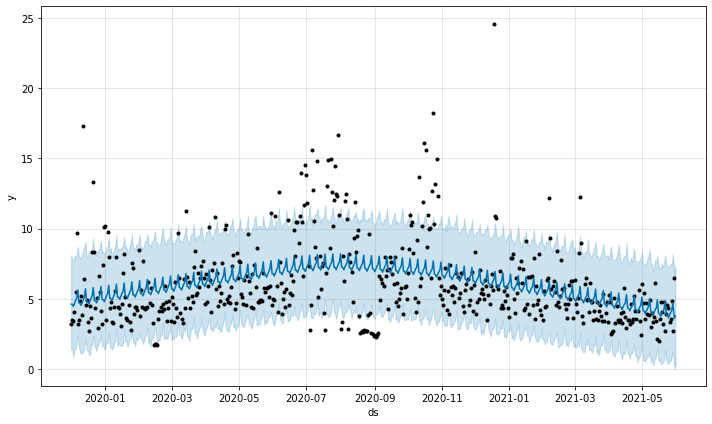

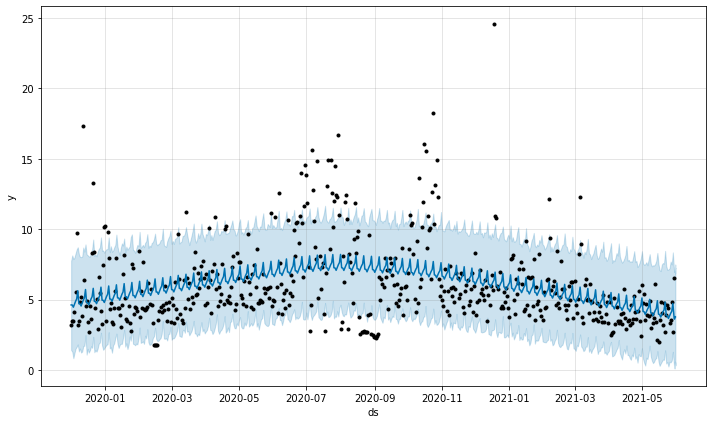

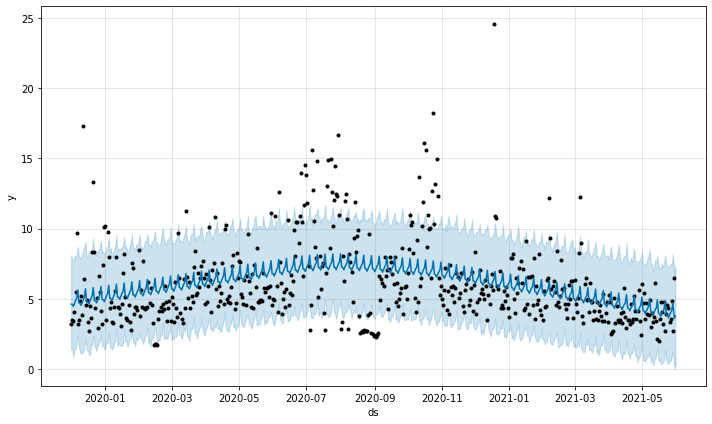

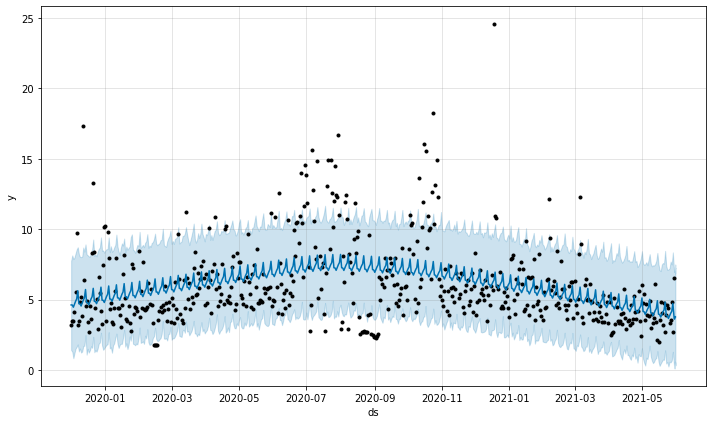

In [ ]:
display(m_electric.plot(forecast_electric))
display(m_electric.plot(future_electric_regressors))


(578, 16)
Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')


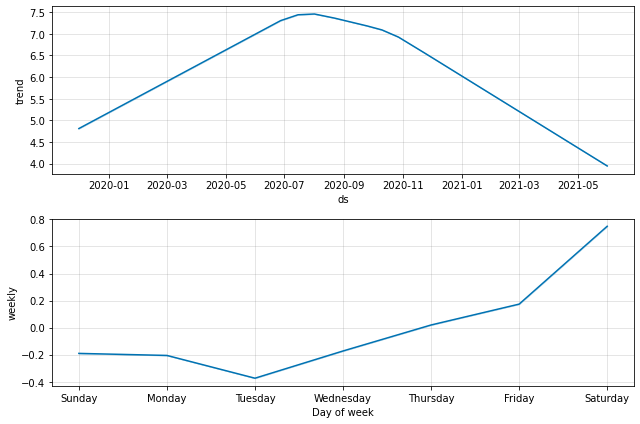

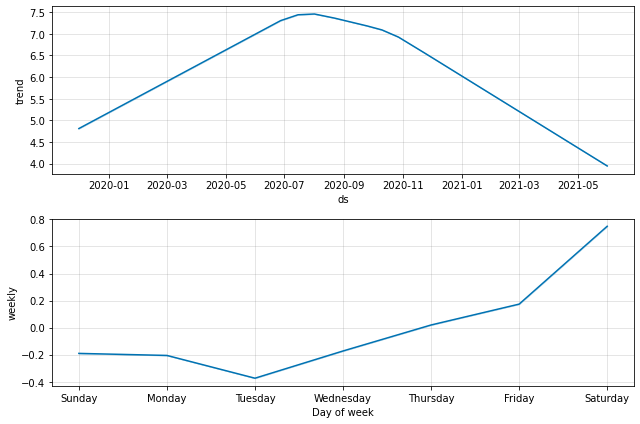

In [ ]:
print(forecast_electric.shape)
print(forecast_electric.columns)
m_electric.plot_components(forecast_electric)